In [1]:
import sys
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from wfdb.processing import gqrs_detect
import pyhrv.time_domain as td
import pyhrv.nonlinear as nl
import pyhrv.frequency_domain as fd
import pandas as pd
import pyunicorn
from scipy.stats import zscore
from scipy.interpolate import interp1d

In [19]:
def grafica(RR_corrected,RR):
    
    plt.figure(figsize=(20, 7))
    plt.title('Variacion de frecuencia cardíaca')
    plt.xlabel('muestra')
    plt.ylabel('intervalo RR (ms)')
    plt.ylim(0.4,1.3)
    x= np.linspace(0,len(ecg[0]), 6)
    plt.plot(np.cumsum(RR_corrected[0]),RR_corrected[0])
    plt.show()
    
    
    plt.figure(figsize=(20, 7))
    plt.title('Variacion de frecuencia cardíaca')
    plt.xlabel('muestra')
    plt.ylabel('intervalo RR (ms)')
    x= np.linspace(0,len(ecg[0]), 6)
    plt.plot(np.cumsum(RR[0]),RR[0])
    plt.show()
    

In [25]:
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values
def preproceso_rr(RR, n_de_segmentos):
    #for i in range(n_de_segmentos):
        outliers = remove_outliers(rr_intervals = RR, 
                                    low_rri = np.mean(RR) - 2 * np.std(RR),
                                    high_rri = np.mean(RR) + 2 * np.std(RR),
                                   verbose = False
                                   )
        interpolated_rr_intervals = interpolate_nan_values(rr_intervals=outliers,
                                                   interpolation_method="linear")
       
        ectopic = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="kamath")
        interpolated_nn_intervals = interpolate_nan_values(rr_intervals=ectopic)
        """
        plt.figure(figsize=(20, 7))
        plt.title('Variacion de frecuencia cardíaca')
        plt.xlabel('muestra')
        plt.ylabel('intervalo RR (ms)')
        plt.ylim(0.4,1.3)
        x= np.linspace(0,len(ecg[0]), 6)
        plt.plot(np.cumsum(interpolated_nn_intervals),interpolated_nn_intervals)
        plt.show()
        """
        
        for i in range(len(interpolated_nn_intervals)):
            if np.isnan(interpolated_nn_intervals[i]):
                interpolated_nn_intervals[i] = np.nanmedian(interpolated_nn_intervals)
        #print('\n',interpolated_nn_intervals)
        
        return interpolated_nn_intervals
    

# Creacion vector temporal-frecuencial

Las ecuaciones a utilizar para el calculo del vector temporal frecuencial son las siguientes:

## Vector temporal

Desviación absoluta media: La desviación media absoluta de una señal es la distancia promedio entre
entre cada muestra y la media, lo que proporciona una estimación de la variabilidad en la señal.

$$
DMA = \sum_{n=1}^\infty\frac{|x_i-\overline{x}|}{N}
$$

Promedio de los intervalos RR:
$$
RRm = \frac{1}{N}\sum_{i=1}^N RR_i
$$

Desviación estándar: refleja la integridad del control autónomo del corazón mediado por el nervio vago (RMSSD, a measure of vagus-mediated heart rate variability, is associated with risk factors for SUDEP: the SUDEP-7 Inventor)

$$
RMSSD = \sqrt{\frac{1}{n - 1} \sum_{j=1}^{n} \Delta {NNI_j}^2}
$$

Desviación estándar de la diferencia entre intervalos RR adyacentes.
$$
SDSD = \sqrt{\frac{1}{n - 1} \sum_{j=1}^{n} (\Delta {NNI_j} - \overline{\Delta NNI})^2}
$$

Desviación estándar de una serie de intervalos NN

$$
SDNN = \sqrt{\frac{1}{n - 1} \sum_{j=1}^{n} (NNI_j - \overline{NNI})^2}
$$

prueba NN50 y PNN50 encuentra el número de diferencias de intervalos NN superiores a 50 ms (NN50) y la relación entre NN50 y el número total de diferencias de intervalos NN.
$$
pNN50 = \frac{NN50}{n}
$$


## Vector frecuencial

Para el calculo frecuencial se utilizó el calculo de la densidad de potencia espectral (PSD) utilizando el metodo de Welch. El algoritmo viene dado de la siguiente manera:

1.- partición de la secuencia de datos:
$$
X[0],x[1],...,x[N-1]
$$

en k segmentos o lotes:

segmento 1: x[0], x[1],...,x[M-1]

segmento 2: x[S],... x[M+S-1]

...

segmento K: x[N-M],.., x[N-1]


donde 
M es el numero de puntos en cada segmento

S los puntos donde se intercambia segmentos

K el numero de segmentos.


2.- se calcula la transformada discreta de fourier (DFT) a cierta frecuencia $\nu = i/M  con (-M/2-1) \leq i \leq M/2:$
$$
X_k(\nu) = \sum_m x[m]\omega[m]e^{-2j\pi \nu m}
$$

donde 
m: (k-1)S,..., M +(k-1)S-1
$\omega[m]$ : funcion ventana

3.- para cada segmento se calcula el valor de periodograma $P_k(\nu)$ de la transformada discreta de fourier.
$$
P_k(\nu) = \frac{1}{W}|X_k(\nu)|^2
$$
donde 
$$
W = \sum_{m=0}^M \omega^2[m]
$$

4.- se promedia el valor del periodograma para obtener la PSD estimada de Welch
$$
S_x(\nu) = \frac{1}{K}\sum_{k=1}^K P_k(\nu)
$$



In [4]:
def variables_temporales(RR, n_de_segmentos):
    desviacion_absoluta_media = np.zeros(n_de_segmentos)
    #print(desviacion_absoluta_media.shape)
    DMA = []
    for i in range(n_de_segmentos):
        RR_mean = np.round(np.mean(RR[i]), decimals=3)
        for j in range(len(RR[i])):
            resta = RR[i][j]-RR_mean
            DMA.append((np.abs(resta)))
        desviacion_absoluta_media[i] = np.round(np.sum(DMA)/len(RR[i]), decimals=3)
    
    for i in range(n_de_segmentos):
        #Variables temporales
        RR_mean = np.round(np.mean(RR[i]), decimals=3)
        rmssd = np.round(td.rmssd(RR[i]), decimals = 3)
        SDSD = np.round(td.sdsd(RR[i])  , decimals = 3)
        SDRR = np.round(td.sdnn(RR[i])  , decimals = 3)
        nn_50 = np.round(td.nn50(RR[i]) , decimals = 3)
        
        
        vector_temporal[i] = [RR_mean,
                         SDRR[0],
                         SDSD[0],
                         rmssd[0],
                         nn_50[0],
                         nn_50[1],
                         desviacion_absoluta_media[i]]
        
       
    
    return(vector_temporal)                       

In [5]:
def variables_frecuenciales(RR, n_de_segmentos, fs):
    for i in range(n_de_segmentos):      
        #print(RR[i])
        welch = fd.welch_psd(RR[i], show = False)
        #burg = fd.ar_psd(RR[i])
        abs_psd = np.round(welch['fft_abs'], decimals=3)
        LF_HF = np.round(welch['fft_ratio'], decimals = 3)        
        vector_frecuencial[i] = [abs_psd[0],
                                 abs_psd[1],
                                 abs_psd[2],                 
                                 LF_HF]
    
    return vector_frecuencial

In [6]:
from pyunicorn.timeseries import recurrence_plot
def variables_nolineales(RR, n_de_muestras):
    
    for i in range(n_de_muestras):
        sd = nl.poincare(RR[i] , show=False)
        sd1 = np.round(sd[1], decimals = 3)
        sd2 = np.round(sd[2], decimals = 3)
        ratio_sd1_sd2 = np.round(sd[3], decimals = 3)
        
        rec_plot = recurrence_plot.RecurrencePlot(RR[i], dim=7, tau=1, recurrence_rate= 0.07 ,metric='euclidean', normalize=True)
        
        
        rec_rate =  rec_plot.recurrence_rate()
        determinismo = rec_plot.determinism()
        trapping_time= rec_plot.trapping_time()
        entropia = rec_plot.diag_entropy()
        l_mean = rec_plot.average_diaglength()
        l_max = rec_plot.max_diaglength()
        
        
        
        
        matrix = rec_plot.recurrence_matrix()
        plt.matshow(matrix, cmap='binary')
        plt.gca().invert_yaxis()
        plt.xlabel('Time')
        plt.ylabel('Time')
        plt.show()
        
        
        vector_nolineal[i] =[ 
                         sd1,
                         sd2,
                         ratio_sd1_sd2,
                         rec_rate, 
                         l_mean,
                         l_max,
                         entropia,
                         trapping_time,
                         determinismo
                         ]
    
    return (vector_nolineal)
        


pyunicorn: Package netCDF4 could not be loaded. Some functionality in class Data might not be available!
pyunicorn: Package netCDF4 could not be loaded. Some functionality in class NetCDFDictionary might not be available!


# Codigo principal

In [7]:
def sample(ecg,duracion,inicio,fin,n):
    #almaceno el registro wfdb en una variable
    #registro = wfdb.rdrecord(archivo+str(ecg),  sampfrom = inicio, sampto= fin, channels = [0]) #paf
    registro = wfdb.rdrecord(archivo+str(ecg),  sampfrom = inicio, sampto= fin, channels = [0])
    #wfdb.plot_wfdb(record = registro, time_units = 'seconds')
    #almaceno la longitud del registro en este caso 5 min
    longitud = duracion*registro.fs 
    #coloco el registro en un arreglo
    sample = registro.p_signal[:longitud] 
    #lo paso a una dimension
    muestra = sample.flatten()  
    #almaceno el nuevo final
    fin = (n+1)*duracion*registro.fs
    
    return muestra , fin, registro.fs 

señal #: 2
duracion de cada segmento:  30 min
cantidad de segmentos: 1
0 ectopic beat(s) have been deleted with kamath rule.


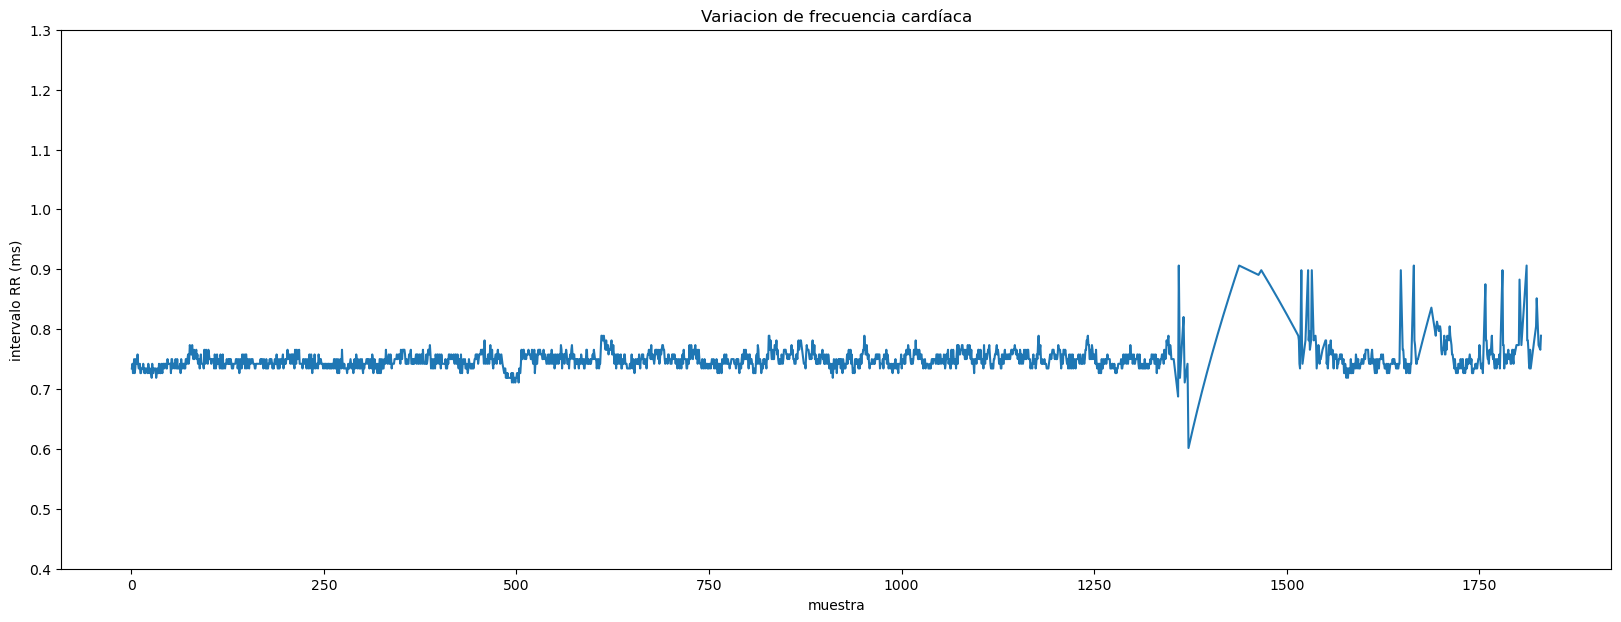

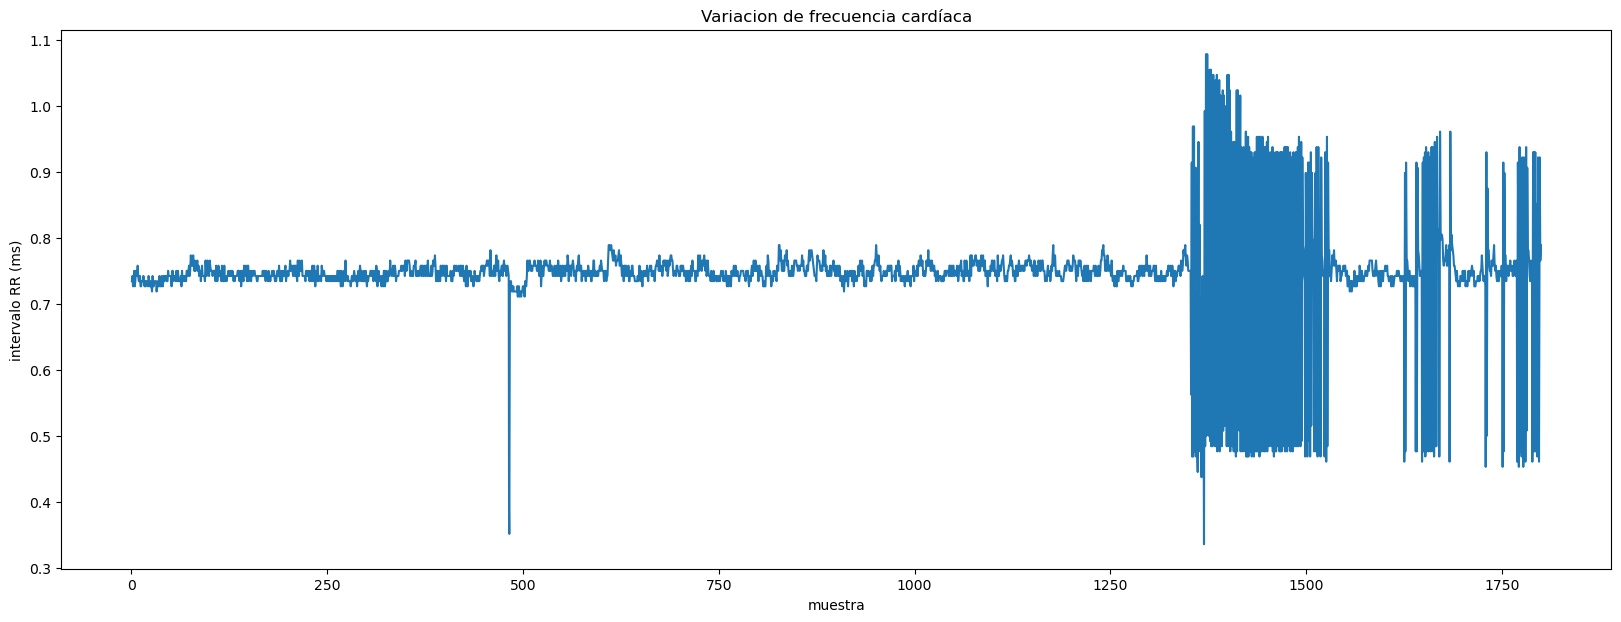

Calculating recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...


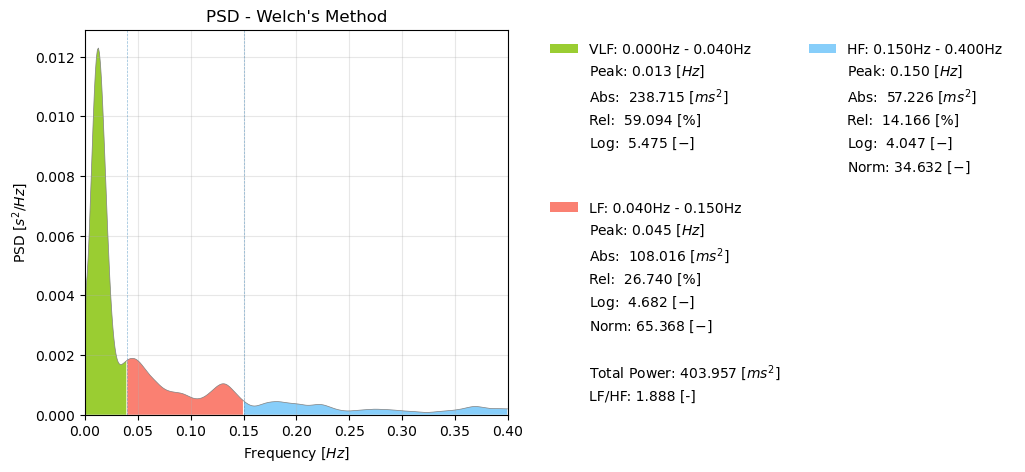

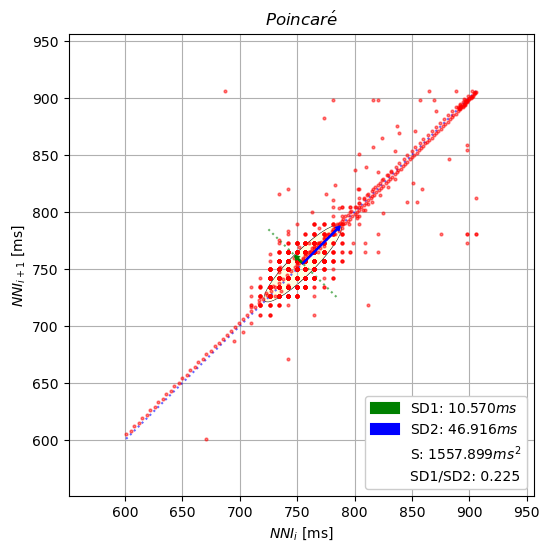

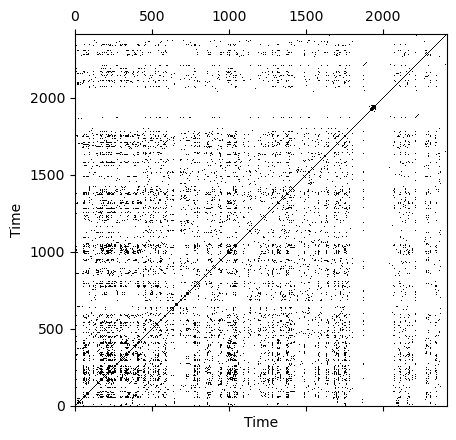

vector completo:
 [[  0.755     ]
 [ 34.011     ]
 [ 11.616     ]
 [ 14.948     ]
 [ 19.        ]
 [  0.784     ]
 [  0.02      ]
 [238.715     ]
 [108.016     ]
 [ 57.226     ]
 [  1.888     ]
 [ 10.57      ]
 [ 46.916     ]
 [  4.439     ]
 [  0.05678694]
 [  4.50542339]
 [171.        ]
 [  2.08593916]
 [  3.19412535]
 [  0.88793475]]


In [30]:
#normal = [16265,16272]#,16273,16420,16483,16539,16773,16786,16795,17052,17453,18177,18184,19088,19090,19093,19140,19830]
for signal in range(2,3):  #se hace una iteración en los archivos a elegir
#for signal in normal:
    #==========================================segmentación señal==============================================
    np.set_printoptions(suppress=True, threshold = sys.maxsize, linewidth = 500)
    
    #PAF pred challenge
    d = 'p0'
    archivo = '/home/gabriel/fisica/Tesis/proyect/bases/paf-database/'+d #ruta del archivo
    print("señal #:", signal) #el numero del archivo
    duracion = 1800 #30min = 1800, 5min = 300
    print('duracion de cada segmento: ',int(duracion/60), 'min')
    ruta = '/home/gabriel/fisica/Proyecto_final/muestras/archivos_csv/'+d+str(signal)+'_'+str(int(duracion*30/1800))+'_min'
    
    
    
    
    """
    #normal sinus rhythm database
    archivo = '/home/gabriel/fisica/Tesis/proyect/bases/mit-bih-nsr-database/' #ruta del archivo
    print("señal #:", signal) #el numero del archivo
    duracion = 300 #30min = 1800
    print('duracion de cada segmento: ',int(duracion/60), 'min')
    ruta = '/home/gabriel/fisica/Proyecto_final/muestras/archivos_csv/'+str(signal)+'_'+str(int(duracion*30/1800))+'_min'
    n_de_segmentos=6
    print('cantidad de segmentos:',n_de_segmentos)
    """
    
    #Tomo la señal usando wfdb verifico cuantos segmentos se tienen y el tiempo de c/u
    
    
    aux = wfdb.rdrecord(archivo+str(signal)) #archivo de entrada
    tiempo_de_segmento = len(aux.p_signal)/aux.fs
    n_de_segmentos = int(tiempo_de_segmento/duracion)
    print('cantidad de segmentos:',n_de_segmentos)
    
    
  #=========================================creación señal VFC===============================================
    
    
    #Se crea el arreglo donde se almacenará la señal de VFC
    ecg = np.zeros((n_de_segmentos,duracion*aux.fs))
    picos = []
    RR = []
    rr_interpol= []
    inicio = 0
    fin = duracion*aux.fs
    
    
    for n in range(n_de_segmentos):
        
        ecg[n,:], fin, fs = sample(signal,duracion,inicio,fin,n+1)
        inicio = int(fin - duracion*aux.fs)
        qrs_inds = gqrs_detect(ecg[n,:], fs=fs) #localizacion picos R
        picos.append(qrs_inds)
    
    for i in range(n_de_segmentos):
        RR.append( np.diff(picos[i]) / fs  )
    
    
    for i in range(n_de_segmentos):
        rr_interpol.append(preproceso_rr(RR[i], n_de_segmentos))
        rr_interpol[i] = np.array(rr_interpol[i], dtype=np.float32)
    
    
    '''
    RR = np.array(RR)
    RR_corrected = np.copy(RR)
    #print(zscore(RR[0]))
    for i in range(n_de_segmentos):
        z_score = zscore(RR[i])
        #print(z_score[0],RR[i,0])
        for j in range(len(RR[i])):
            if np.abs(z_score[j]) > 2:
                #print('zscore : ',z_score[j])
                #print(RR[i,j])
                RR_corrected[i,j] = np.median(RR[i])
                #print(RR_corrected[i,j])
    
    
    '''
    grafica(rr_interpol, RR)   
    RR = np.copy(rr_interpol)
    #print(len(RR))
    
    
    
    #==========================================creación vectores==============================================
    vector_temporal= np.zeros((n_de_segmentos , 7))
    vector_temporal = variables_temporales(RR, n_de_segmentos)
    vector_frecuencial = np.zeros((n_de_segmentos, 4))
    vector_frecuencial = variables_frecuenciales(RR, n_de_segmentos, aux.fs)
    vector_nolineal = np.zeros((n_de_segmentos, 9))
    matrix = variables_nolineales(RR, n_de_segmentos)
    
    #==========================================vector caracteristico==============================================
    
    caracteristicas =  vector_temporal.shape[1]+ vector_frecuencial.shape[1] + vector_nolineal.shape[1]
    
    #===================================================para 30 min====================================================
    vector = np.zeros((n_de_segmentos, caracteristicas ))
    for i in range(n_de_segmentos):
        vector[i] = np.concatenate([vector_temporal[i],vector_frecuencial[i], vector_nolineal[i]],axis=0)
    print('vector completo:\n' ,np.transpose(vector))
    
     #==================================================para 15 min====================================================
    
    #vector = np.zeros((1,caracteristicas))
    #vector[0] = np.concatenate([vector_temporal[-1],vector_frecuencial[-1], vector_nolineal[-1]],axis=0)
    
    #print('ultimos 15min:\n' ,vector)
    #np.savetxt(ruta+'.txt', vector, fmt= '%.3f', delimiter = ';')
    